In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import tszip

In [2]:
regions = [
    ("ORF1ab", 266, 21555),
    ("S", 21563, 25384),
    ("ORF3", 25393, 26220),
    ("E", 26245, 26472),
    ("M", 26523, 27191),
    ("ORF6", 27202, 27387),
    ("ORF7a", 27394, 27759),
    ("ORF7b", 27756, 27887),
    ("ORF8", 27894, 28259),
    ("N", 28274, 29533),
    ("ORF10", 29558, 29674)]

def get_genome_region(pos): 
    for label, start, end in regions:
        if start <= pos <= end:
            return label
    return "non-coding"


ORF1AB_regions = [
    ("NSP1", 266, 805),
    ("NSP2", 806, 2719),
    ("NSP3", 2720, 8554),
    ("NSP4", 8555, 10054),
    ("NSP5", 10055, 10972),
    ("NSP6", 10973, 11842),
    ("NSP7", 11843, 12091),
    ("NSP8", 12092, 12685),
    ("NSP9", 12686, 13024),
    ("NSP10", 13025, 13441),
    ("NSP12", 13441, 16236),  # frameshift happens here
    ("NSP13", 16237, 18039),
    ("NSP14", 18040, 19620),
    ("NSP15", 19621, 20658),
    ("NSP16", 20659, 21552)
]

def get_ORF1AB_region(pos):
    for label, start, end in ORF1AB_regions:
        if start <= pos <= end:
            return label
    return ""


spike_subregions = [
    ("S1-NTD-signal peptide", 21563, 21601),
    ("S1-NTD", 21563, 22475),
    ("S1-RBD", 22517, 23185),
    ("S1/2 cleavage site", 22517, 23185),
    ("S1-other", 21563, 23617),
    ("S2-Fusion peptide", 23924, 23980),
    ("S2-HR1", 24296, 24514),
    ("HR2", 25049, 25201),
    ("TM domain", 25202, 25273),
    ("CTD", 25274, 25383),
    ("S2-other", 23618, 25383)]

def get_spike_domain(pos):
    for label, start, end in spike_subregions:
        if start <= pos <= end:
            return label
    return ""

In [3]:
data_dir = Path("../data")
ts_file = data_dir / "sc2ts_viridian_v1.1.trees.tsz"
ts = tszip.load(ts_file)

In [4]:
pp_dir = Path("../arg_postprocessing")
events_file = pp_dir / "sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_deletion_events.csv"
events_df = pd.read_csv(events_file, index_col=0)
events_df["region"] = events_df["start"].apply(get_genome_region)
events_df["ORF1AB_region"] = events_df["start"].apply(get_ORF1AB_region)
events_df["spike_region"] = events_df["start"].apply(get_spike_domain)
events_df["pango"] = events_df["node"].apply(lambda x: ts.node(x).metadata["pango"])
events_df["deletion"] = events_df.apply(lambda row: tuple(range(row["start"], row["start"] + row["length"])), axis=1)
events_df["sc2ts_freq"] = np.round(events_df["max_inheritors"] / ts.num_samples * 100, decimals=4)
events_df = events_df.sort_values(by="min_inheritors", ascending=False)
events_df

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
30086,28271,1436808,1,1118363,1118363,non-coding,,,B.1,"(28271,)",45.0561
27869,28248,220186,6,1114669,1114326,ORF8,,,B.1.617.2,"(28248, 28249, 28250, 28251, 28252, 28253)",44.9073
14712,22029,200039,6,1112410,1111939,S,,S1-NTD,B.1.617.2,"(22029, 22030, 22031, 22032, 22033, 22034)",44.8163
8248,11288,1436802,4,871782,871762,ORF1ab,NSP6,,B.1.1.529,"(11288, 11289, 11290, 11291)",35.1220
8249,28362,1436802,9,871774,850272,N,,,B.1.1.529,"(28362, 28363, 28364, 28365, 28366, 28367, 283...",35.1216
...,...,...,...,...,...,...,...,...,...,...,...
43823,29541,909260,1,1,1,non-coding,,,AY.103,"(29541,)",0.0000
43822,29781,909255,1,1,1,non-coding,,,AY.103,"(29781,)",0.0000
43821,29779,909255,1,1,1,non-coding,,,AY.103,"(29779,)",0.0000
43820,29774,909255,1,1,1,non-coding,,,AY.103,"(29774,)",0.0000


In [5]:
major_events_df = events_df[events_df["max_inheritors"] >= 10_000].reset_index(drop=True)
major_events_df

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
0,28271,1436808,1,1118363,1118363,non-coding,,,B.1,"(28271,)",45.0561
1,28248,220186,6,1114669,1114326,ORF8,,,B.1.617.2,"(28248, 28249, 28250, 28251, 28252, 28253)",44.9073
2,22029,200039,6,1112410,1111939,S,,S1-NTD,B.1.617.2,"(22029, 22030, 22031, 22032, 22033, 22034)",44.8163
3,11288,1436802,4,871782,871762,ORF1ab,NSP6,,B.1.1.529,"(11288, 11289, 11290, 11291)",35.1220
4,28362,1436802,9,871774,850272,N,,,B.1.1.529,"(28362, 28363, 28364, 28365, 28366, 28367, 283...",35.1216
5,21633,822854,9,532072,531990,S,,S1-NTD,BA.2,"(21633, 21634, 21635, 21636, 21637, 21638, 216...",21.4359
6,11292,822854,5,531894,531867,ORF1ab,NSP6,,BA.2,"(11292, 11293, 11294, 11295, 11296)",21.4287
7,6513,851246,3,340765,340751,ORF1ab,NSP3,,BA.1,"(6513, 6514, 6515)",13.7286
8,11283,851246,5,339867,339865,ORF1ab,NSP6,,BA.1,"(11283, 11284, 11285, 11286, 11287)",13.6924
9,21765,851246,6,339681,339472,S,,S1-NTD,BA.1,"(21765, 21766, 21767, 21768, 21769, 21770)",13.6849


In [6]:
who_pango = {
    "B.1.1.7": "B.1.1.7 (Alpha)",
    "B.1.617.2": "B.1.617.2 (Delta)",
    "BA.1": "BA.1 (Omicron)",
    "BA.2": "BA.2 (Omicron)",
    "BA.4": "BA.4 (Omicron)",
    "BA.5.2.1": "BA.5.2.1 (Omicron)",
}


latex_tab_major_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Major deletion events in the ARG.}' + "\n" + \
r'\label{tab:major_dels}' + "\n" + \
r'\begin{tabular}{rrcrcrr}' + "\n" + \
r'\toprule' + "\n" + \
r'Start & Length & Region & Node & Pango lineage & Count & Frequency (\%)\\' + "\n" + \
r'\midrule' + "\n"

for row in major_events_df.itertuples():
    sc2ts_count = f"{int(row.max_inheritors)}"
    sc2ts_freq = f"{row.sc2ts_freq:.4f}"
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    pango = who_pango[row.pango] if row.pango in who_pango else row.pango
    latex_tab_major_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{row.node} & {pango} & " + \
        f"{sc2ts_count} & {sc2ts_freq}" + r' \\' + "\n"

latex_tab_major_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_major_dels)

\begin{table}
\centering
\caption{Major deletion events in the ARG.}
\label{tab:major_dels}
\begin{tabular}{rrcrcrr}
\toprule
Start & Length & Region & Node & Pango lineage & Count & Frequency (\%)\\
\midrule
28271 & 1 & non-coding & 1436808 & B.1 & 1118363 & 45.0561 \\
28248 & 6 & ORF8 & 220186 & B.1.617.2 (Delta) & 1114669 & 44.9073 \\
22029 & 6 & S / S1-NTD & 200039 & B.1.617.2 (Delta) & 1112410 & 44.8163 \\
11288 & 4 & ORF1ab / NSP6 & 1436802 & B.1.1.529 & 871782 & 35.1220 \\
28362 & 9 & N & 1436802 & B.1.1.529 & 871774 & 35.1216 \\
21633 & 9 & S / S1-NTD & 822854 & BA.2 (Omicron) & 532072 & 21.4359 \\
11292 & 5 & ORF1ab / NSP6 & 822854 & BA.2 (Omicron) & 531894 & 21.4287 \\
6513 & 3 & ORF1ab / NSP3 & 851246 & BA.1 (Omicron) & 340765 & 13.7286 \\
11283 & 5 & ORF1ab / NSP6 & 851246 & BA.1 (Omicron) & 339867 & 13.6924 \\
21765 & 6 & S / S1-NTD & 851246 & BA.1 (Omicron) & 339681 & 13.6849 \\
21988 & 8 & S / S1-NTD & 851246 & BA.1 (Omicron) & 339651 & 13.6837 \\
22194 & 3 & S / S1-NTD 

Table 1: Deletion events which have more than 10k inheritors. Of these 18 deletions, eight are located in the N-terminal domain of Spike, a previously noted site for key deletions. Many of these nodes represent the origins of major lineages, for example the 851246 node which represents the origin of BA.1, and the 86456 node which represents the origin of Alpha.

In [7]:
rec_dels_df = events_df[["start", "length", "region", "ORF1AB_region", "spike_region"]]\
    .value_counts()\
    .reset_index(name="occurrences")[:20]
rec_dels_df

,start,length,region,ORF1AB_region,spike_region,occurrences
0,29781,1,non-coding,,,12713
1,29762,1,non-coding,,,11356
2,29779,1,non-coding,,,10925
3,29769,1,non-coding,,,10783
4,29774,1,non-coding,,,10707
5,29700,1,non-coding,,,8543
6,29614,1,ORF10,,,5041
7,29555,1,non-coding,,,4816
8,29543,1,non-coding,,,4806
9,29541,1,non-coding,,,4804


In [8]:
latex_tab_rec_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Highly recurrent deletions.}' + "\n" + \
r'\label{tab:rec_dels}' + "\n" + \
r'\begin{tabular}{rrcr}' + "\n" + \
r'\toprule' + "\n" + \
r'Start & Length & Region & Occurrences \\' + "\n" + \
r'\midrule' + "\n"

for row in rec_dels_df.itertuples():
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    latex_tab_rec_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{row.occurrences}" + r' \\' + "\n"

latex_tab_rec_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_rec_dels)

\begin{table}
\centering
\caption{Highly recurrent deletions.}
\label{tab:rec_dels}
\begin{tabular}{rrcr}
\toprule
Start & Length & Region & Occurrences \\
\midrule
29781 & 1 & non-coding & 12713 \\
29762 & 1 & non-coding & 11356 \\
29779 & 1 & non-coding & 10925 \\
29769 & 1 & non-coding & 10783 \\
29774 & 1 & non-coding & 10707 \\
29700 & 1 & non-coding & 8543 \\
29614 & 1 & ORF10 & 5041 \\
29555 & 1 & non-coding & 4816 \\
29543 & 1 & non-coding & 4806 \\
29541 & 1 & non-coding & 4804 \\
203 & 1 & non-coding & 3602 \\
222 & 1 & non-coding & 3441 \\
22013 & 6 & S / S1-NTD & 2111 \\
21991 & 3 & S / S1-NTD & 2087 \\
28254 & 1 & ORF8 & 1967 \\
27556 & 64 & ORF7a & 1281 \\
27579 & 3 & ORF7a & 1014 \\
28093 & 1 & ORF8 & 898 \\
21765 & 6 & S / S1-NTD & 478 \\
27532 & 1 & ORF7a & 403 \\
\bottomrule
\end{tabular}
\end{table}


Table 2: Highly recurrent deletions in the ARG. The majority of these recurrent deletions are located in the non-coding region, but some are in coding regions such as 21991-21993 and 22013-22018 in Spike.

In [9]:
# https://figshare.com/articles/figure/Identifying_featured_indels_associated_with_SARS-CoV-2_fitness/21834957
tabs1_url = "https://figshare.com/ndownloader/files/40119535"
tabs1_df = pd.read_excel(tabs1_url)

tabs1_df.rename(columns={"Start": "start", "Length": "length"}, inplace=True)

tabs1_df["region"] = tabs1_df["start"].apply(get_genome_region)
tabs1_df["ORF1AB_region"] = tabs1_df["start"].apply(get_ORF1AB_region)
tabs1_df["spike_region"] = tabs1_df["start"].apply(get_spike_domain)

# "In total, 31,642,407 deletion records and 1,981,308 insertion records were detected 
# in 9,149,680 filtered genomic sequences after removing indel records in 5′ and 3′ untranslated regions (UTR), and 
# there were 26,765 different types of deletions and 21,054 different types of insertions (Table S1)."
num_samples_li = 9149680

tabs1_df["li_freq"] = np.round(tabs1_df["Count"] / num_samples_li * 100, decimals=4)
tabs1_df.head(5)

,Name,start,length,Count,Gene,Frameshift/Non-frameshift,region,ORF1AB_region,spike_region,li_freq
0,Del_10000_1,10000,1,1,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
1,Del_10005_2,10005,2,1,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
2,Del_10007_1,10007,1,4,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
3,Del_10008_3,10008,3,1,ORF1ab-nsp4,non-frameshift,ORF1ab,NSP4,,0.0
4,Del_10011_1,10011,1,3,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0


In [10]:
# Check that these are all deletions in Table S1.
# It is odd that there are only deletions but Li et al. (2023) say there are also insertions.
all(tabs1_df["Name"].str.startswith("Del_"))

True

In [11]:
agg_dels_df = events_df.groupby(["start", "length"])\
.agg({
    'start': 'first',
    'length': 'first',
    'node': 'unique',
    'pango': 'unique',
    'max_inheritors': 'sum',
    'region': 'first',
    'ORF1AB_region': 'first',
    'spike_region': 'first',
})\
.sort_values(by='max_inheritors', ascending=False)\
.reset_index(drop=True)
agg_dels_df["agg_sc2ts_freq"] = np.round(agg_dels_df["max_inheritors"] / ts.num_samples * 100, decimals=4)
agg_dels_df.head(5)

,start,length,node,pango,max_inheritors,region,ORF1AB_region,spike_region,agg_sc2ts_freq
0,28271,1,"[1436808, 86456, 154138, 202525, 155424, 22324...","[B.1, B.1.1.7, B.1.526, B.1.637, R.1, C.17, AV...",1422469,non-coding,,,57.3078
1,28248,6,"[220186, 2730440, 140148, 2703654, 2735639, 51...","[B.1.617.2, B.1.1.7, BA.1.1, BA.1.15, BQ.1.1, ...",1114712,ORF8,,,44.9090
2,22029,6,"[200039, 360718, 2711715, 476707, 538864, 4673...","[B.1.617.2, AY.39, AY.4, AY.42, AY.107, AY.119...",1114415,S,,S1-NTD,44.8970
3,11288,4,"[1436802, 194273]","[B.1.1.529, B.1.214]",871838,ORF1ab,NSP6,,35.1242
4,28362,9,"[1436802, 2173373, 1717027, 1063584, 161260]","[B.1.1.529, AY.4.2.1, AY.4, BA.1.1, B.1.526]",871778,N,,,35.1218


In [12]:
# Check one case.
sum(events_df[(events_df["start"] == 28271) & (events_df["length"] == 1)]['max_inheritors'])

1422469

In [13]:
agg_dels_df = agg_dels_df.merge(
    tabs1_df,
    how="outer",    # NOTE
    left_on=["start", "length", "region", "ORF1AB_region", "spike_region"],
    right_on=["start", "length", "region", "ORF1AB_region", "spike_region"],
)[[
    "start", "length", "region", "ORF1AB_region", "spike_region",
    "max_inheritors", "agg_sc2ts_freq", "Count", "li_freq",
]]
agg_dels_df.head(5)

,start,length,region,ORF1AB_region,spike_region,max_inheritors,agg_sc2ts_freq,Count,li_freq
0,203,1,non-coding,,,4655.0,0.1875,NaN,NaN
1,222,1,non-coding,,,4348.0,0.1752,NaN,NaN
2,269,2,ORF1ab,NSP1,,NaN,NaN,1.0,0.0
3,270,60,ORF1ab,NSP1,,NaN,NaN,1.0,0.0
4,271,9,ORF1ab,NSP1,,NaN,NaN,1.0,0.0


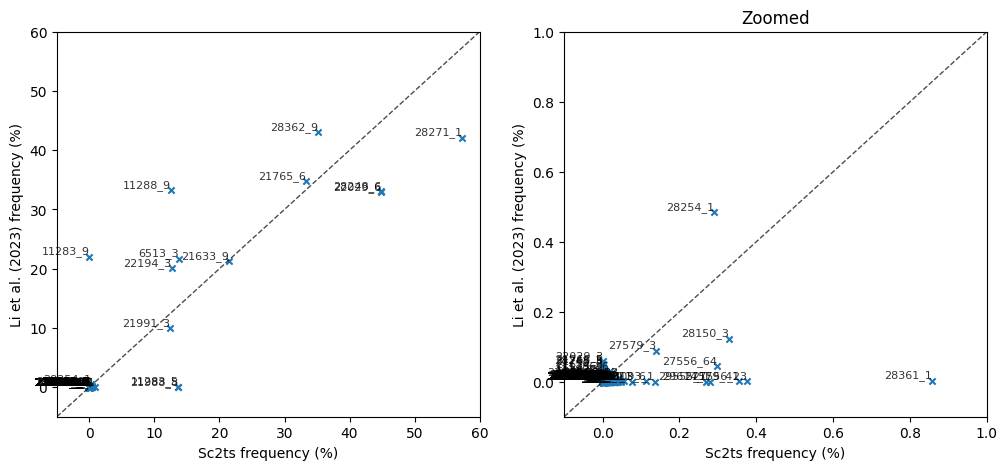

In [14]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].scatter(
    x=agg_dels_df["agg_sc2ts_freq"],
    y=agg_dels_df["li_freq"],
    s=20,
    marker='x',
)
ax[0].set_xlim(-5, 60)
ax[0].set_ylim(-5, 60)
ax[0].set_xlabel("Sc2ts frequency (%)")
ax[0].set_ylabel("Li et al. (2023) frequency (%)")
for i, row in agg_dels_df.iterrows():
    ax[0].text(
        row["agg_sc2ts_freq"],
        row["li_freq"],
        str(row["start"]) + "_" + str(row["length"]),
        fontsize=8,
        alpha=0.8,
        ha='right',
        va='bottom',
    )
ax[0].axline((0, 0), slope=1, color='k', linestyle='--', lw=1, alpha=0.7)


ax[1].set_title("Zoomed")
ax[1].scatter(
    x=agg_dels_df["agg_sc2ts_freq"],
    y=agg_dels_df["li_freq"],
    s=20,
    marker='x',
)
ax[1].set_xlim(-0.1, 1)
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel("Sc2ts frequency (%)")
ax[1].set_ylabel("Li et al. (2023) frequency (%)")
for i, row in agg_dels_df.iterrows():
    if row["agg_sc2ts_freq"] > 1.0 or row["li_freq"] > 1.0:
        continue
    ax[1].text(
        row["agg_sc2ts_freq"],
        row["li_freq"],
        str(row["start"]) + "_" + str(row["length"]),
        fontsize=8,
        alpha=0.8,
        ha='right',
        va='bottom',
    )
ax[1].axline((0, 0), slope=1, color='k', linestyle='--', lw=1, alpha=0.7);

In [15]:
common_dels_df = agg_dels_df[
    (agg_dels_df["agg_sc2ts_freq"] >= 1.0) | (agg_dels_df["li_freq"] >= 1.0)
]\
.sort_values(by="agg_sc2ts_freq", ascending=False)\
.reset_index(drop=True)
common_dels_df

,start,length,region,ORF1AB_region,spike_region,max_inheritors,agg_sc2ts_freq,Count,li_freq
0,28271,1,non-coding,,,1422469.0,57.3078,3853692.0,42.1183
1,28248,6,ORF8,,,1114712.0,44.9090,3026186.0,33.0742
2,22029,6,S,,S1-NTD,1114415.0,44.8970,3010665.0,32.9046
3,11288,4,ORF1ab,NSP6,,871838.0,35.1242,NaN,NaN
4,28362,9,N,,,871778.0,35.1218,3939164.0,43.0525
5,21765,6,S,,S1-NTD,825628.0,33.2625,3179887.0,34.7541
6,21633,9,S,,S1-NTD,532084.0,21.4364,1941962.0,21.2244
7,11292,5,ORF1ab,NSP6,,531943.0,21.4307,NaN,NaN
8,6513,3,ORF1ab,NSP3,,341714.0,13.7668,1984683.0,21.6913
9,11283,5,ORF1ab,NSP6,,339935.0,13.6951,8360.0,0.0914


In [16]:
latex_tab_common_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Most commonly observed deletions in the ARG or Li et al. (2023).} ' + "\n" + \
r'\label{tab:common_dels}' + "\n" + \
r'\begin{tabular}{rrcrrrr}' + "\n" + \
r'\toprule' + "\n" + \
r'\multicolumn{3}{c}{} & \multicolumn{2}{c}{Sc2ts ARG} & \multicolumn{2}{c}{Li et al. (2023)} \\' + "\n" + \
r'\cmidrule(lr){4-5} \cmidrule(lr){6-7}' + "\n" + \
r'Start & Length & Region & Count & Frequency (\%) & Count & Frequency (\%) \\' + "\n" + \
r'\midrule' + "\n"

for row in common_dels_df.itertuples():
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    sc2ts_count = "N/A" if np.isnan(row.max_inheritors) else f"{int(row.max_inheritors)}"
    sc2ts_freq = "N/A" if np.isnan(row.agg_sc2ts_freq) else f"{row.agg_sc2ts_freq:.4f}"
    li_count = "N/A" if np.isnan(row.Count) else f"{int(row.Count)}"
    li_freq = "N/A" if np.isnan(row.li_freq) else f"{row.li_freq:.4f}"
    latex_tab_common_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{sc2ts_count} & {sc2ts_freq} & {li_count} & {li_freq}" + r' \\' + "\n"

latex_tab_common_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_common_dels)

\begin{table}
\centering
\caption{Most commonly observed deletions in the ARG or Li et al. (2023).} 
\label{tab:common_dels}
\begin{tabular}{rrcrrrr}
\toprule
\multicolumn{3}{c}{} & \multicolumn{2}{c}{Sc2ts ARG} & \multicolumn{2}{c}{Li et al. (2023)} \\
\cmidrule(lr){4-5} \cmidrule(lr){6-7}
Start & Length & Region & Count & Frequency (\%) & Count & Frequency (\%) \\
\midrule
28271 & 1 & non-coding & 1422469 & 57.3078 & 3853692 & 42.1183 \\
28248 & 6 & ORF8 & 1114712 & 44.9090 & 3026186 & 33.0742 \\
22029 & 6 & S / S1-NTD & 1114415 & 44.8970 & 3010665 & 32.9046 \\
11288 & 4 & ORF1ab / NSP6 & 871838 & 35.1242 & N/A & N/A \\
28362 & 9 & N & 871778 & 35.1218 & 3939164 & 43.0525 \\
21765 & 6 & S / S1-NTD & 825628 & 33.2625 & 3179887 & 34.7541 \\
21633 & 9 & S / S1-NTD & 532084 & 21.4364 & 1941962 & 21.2244 \\
11292 & 5 & ORF1ab / NSP6 & 531943 & 21.4307 & N/A & N/A \\
6513 & 3 & ORF1ab / NSP3 & 341714 & 13.7668 & 1984683 & 21.6913 \\
11283 & 5 & ORF1ab / NSP6 & 339935 & 13.6951 & 8360 & 0.0

Table 3: Deletions commonly observed in the Sc2ts ARG and Li et al. (2023). These deletions occur at least 1% of the samples analyzed.